# Introduction to Spanish NLP Workshop
First let's load [spacy](https://spacy.io) and a Spanish parsing model, this may take a while

In [8]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import codecs
import math

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors

# Display plots in this notebook, instead of externally. 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline
nlp = spacy.load('es')

### Tokenization and POS Tagging
Now we can a pick a sentence and analyze it. A sentence is split into **tokens** (units of meaning: could be more than one word in some cases) and we can get the syntactic function of each one. This is called **POS** (Part of Speech) tagging

In [9]:
doc = nlp('Las naranjas y las manzanas se parecen')
pd.DataFrame([[word.text, word.tag_, word.pos_] for word in doc], columns=['Token', 'TAG', 'POS'])

,Token,TAG,POS
0,Las,DET__Gender=Fem|Number=Plur|PronType=Art,DET
1,naranjas,NOUN__Gender=Fem|Number=Plur,NOUN
2,y,CCONJ___,CONJ
3,las,DET__Definite=Def|Gender=Fem|Number=Plur|PronT...,DET
4,manzanas,NOUN__Gender=Fem|Number=Plur,NOUN
5,se,PRON__Person=3,PRON
6,parecen,VERB__Mood=Ind|Number=Plur|Person=3|Tense=Pres...,VERB


### Language Models
Anothe key concept in NLP is that of **Language Models**. It is a function that is able to tell us the likelihood of a sentence of appearing in the real word. One such model, albeit a very simple one, is the one that multiplies the probabilities of every token in the sentence

In [17]:
pd.DataFrame([[word.text, math.exp(word.prob), word.prob] for word in doc], columns=['Token', 'Prob', 'Log Prob'])

,Token,Prob,Log Prob
0,Las,0.000644,-7.347541
1,naranjas,0.000004,-12.366278
2,y,0.020835,-3.871129
3,las,0.007129,-4.943562
4,manzanas,0.000006,-12.064260
5,se,0.007493,-4.893838
6,parecen,0.000036,-10.242378


### Names Entity Recognition
We are also interested in extracting the proper entities that appear in a phrase and this problem is referred as **Named Entity Recognition** or **NER**. Here's and example with different kinds of entities such as *people* and *locations*

In [23]:
doc2 = nlp(u"La premier alemana Angela Merkel visitó Buenos Aires esta semana")
for ent in doc2.ents:
    print('{} \t {}'.format(ent, ent.label_))

Angela Merkel 	 PERSON
Buenos Aires 	 LOC


### Word Embeddings

Embeddings are the silver bullet brought from the world of deep learning into the realm of NLP through the **word2vec** algorithm. They are a meaningful
representation of tokens as a dense high dimensional vector. They can be obtained from large unlabelled **corpora** easily available
on the web and are able to express the sintactic, semantic, morpholical and even polysemic richness of a word in a way that 
a computer can understand

In [37]:
orange = doc[1]
apple = doc[4]
orange.similarity(apple)

0.83445842963978367

One amazing property of word vectors is that they represent analogies really well, for instance:
 
 * Argentina - Macri = Alemania - Merkel
 * Reina - Mujer = Rey - Hombre
 
We can also average out the vectors in a whole sentence to get a similarity between them. NLP methods that disregard the word order such as this one are commonly referred as **Bag of Words**

In [41]:
doc.similarity(doc2)

0.82128151045732101

### Let's look at some real world data
These is are the [last 100 news articles](http://api-editoriales.clarin.com/api/instant_articles?limit=100) at clarin.com, the biggest news media outlet in Argentina

In [121]:
from bs4 import BeautifulSoup
import urllib.request
html = urllib.request.urlopen('http://api-editoriales.clarin.com/api/instant_articles?limit=100').read()
soup = BeautifulSoup(html, 'html.parser')
news = [
    BeautifulSoup(c.text, 'html.parser').text.split('function', 1)[0] 
    for item in soup.findAll('item') 
        for c in item.children if c.name == 'content:encoded'
]
news[0][0:100]

'De Vido, López y Jaime estarían en la lista de sobornos de la brasileña OdebrechtDe Vido, López y Ja'

In [124]:
corpus = nlp('\n'.join(news))

In [155]:
visited = {}
nouns = []
for word in corpus:
    if word.pos_.startswith('N') and len(word.string) < 15:
        token = word.string.strip().lower()
        if token in visited:
            visited[token] += 1
            continue
        else:
            visited[token] = 1
            nouns.append(word)
nouns = sorted(nouns, key=lambda w: -visited[w.string.strip().lower()])[:150]
pd.DataFrame([[w.text, visited[w.string.strip().lower()]] for w in nouns], columns=['Noun', 'Freq'])

,Noun,Freq
0,2017,241
1,Junio,158
2,años,149
3,dos,115
4,edificio,69
5,año,65
6,vez,62
7,tres,59
8,país,58
9,parte,56


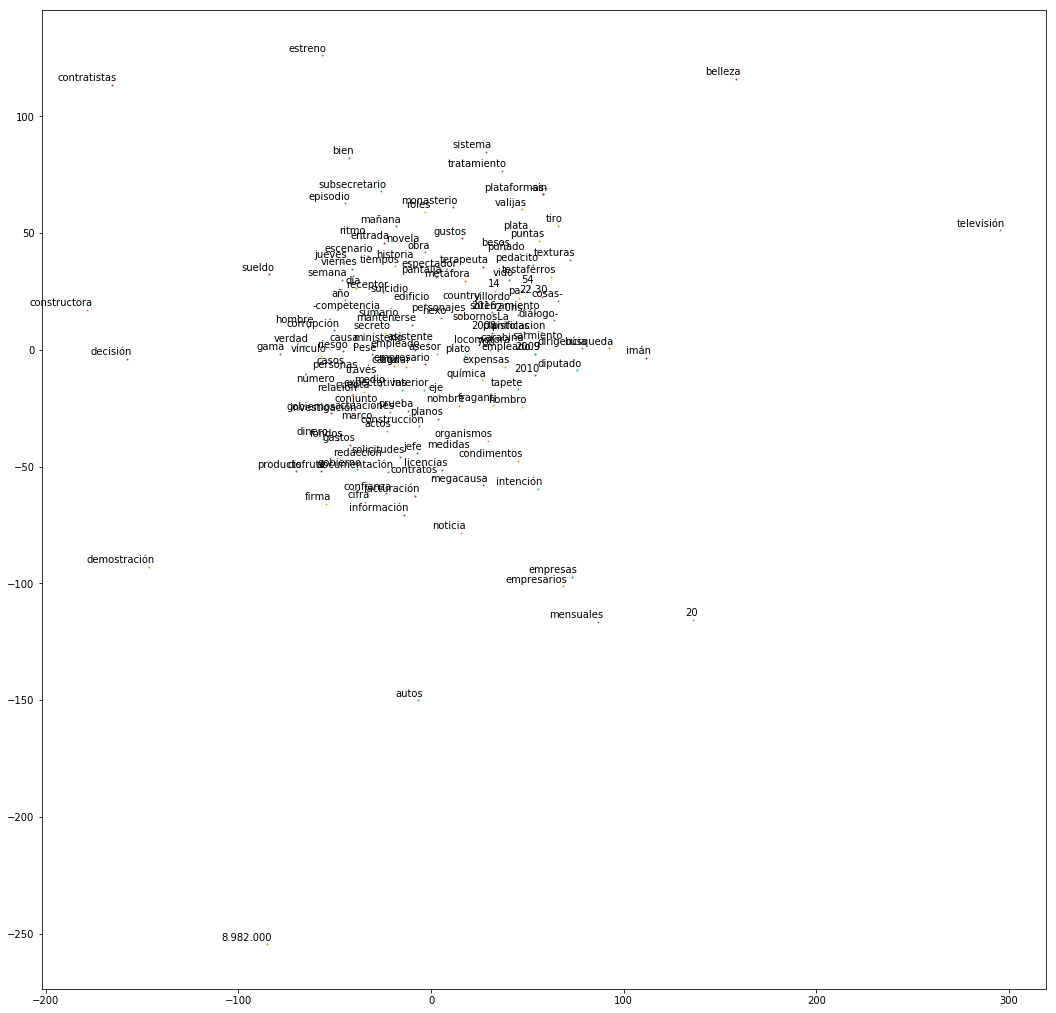

In [152]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y, s=1.0)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()
#     plt.savefig(filename)

# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=30.0, n_components=2, init='pca', n_iter=5000)

low_dim_embedding = tsne.fit_transform(np.array([word.vector for word in nouns]))

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, [word.text for word in nouns])